In [ ]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333) 
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [24]:
# https://jovianlin.io/embeddings-in-keras/
# 참고사이트
import re
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
docs = ['Well done!', 'Good work', 'Great effort', 'nice work', 'Excellent!',
        'Weak', 'Poor effort!', 'not good', 'poor work', 'Could have done better.']

labels = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [37]:
own_embedding_vocab_size = 10
encoded_docs_oe = [one_hot(d, own_embedding_vocab_size) for d in docs]
print(encoded_docs_oe)
print(len(encoded_docs_oe))

[[5, 3], [3, 9], [9, 4], [7, 9], [7], [5], [6, 4], [7, 3], [6, 9], [3, 8, 3, 2]]
10


In [39]:
maxlen = 5
padded_decs_oe = pad_sequences(encoded_docs_oe, maxlen=maxlen, padding='post')
print(padded_decs_oe)
print(padded_decs_oe.shape)

[[5 3 0 0 0]
 [3 9 0 0 0]
 [9 4 0 0 0]
 [7 9 0 0 0]
 [7 0 0 0 0]
 [5 0 0 0 0]
 [6 4 0 0 0]
 [7 3 0 0 0]
 [6 9 0 0 0]
 [3 8 3 2 0]]
(10, 5)


In [27]:
model = Sequential()
model.add(Embedding(input_dim=own_embedding_vocab_size, output_dim=32, input_length=maxlen))
model.add(Bidirectional(LSTM(32,activation='relu',recurrent_dropout=0.1,return_sequences)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])  # Compile the model
print(model.summary())  # Summarize the model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5, 32)             320       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
model.fit(padded_decs_oe, labels, epochs=50, verbose=0)  # Fit the model
loss, accuracy = model.evaluate(padded_decs_oe, labels, verbose=0)  # Evaluate the model
print('loss : %0.3f'%loss ,'Accuracy: %0.3f' % accuracy)

loss : 0.153 Accuracy: 0.900


In [31]:
padded_decs_oe[1:2]

array([[3, 9, 0, 0, 0]])

In [42]:
word = "Good work"
word_docs_oe = [one_hot(word, own_embedding_vocab_size)]
word_oe = pad_sequences(word_docs_oe, maxlen=maxlen, padding='post')
pred = model.predict(word_oe)
np.round(pred)

array([[1.]], dtype=float32)

In [43]:
s = padded_decs_oe
a = model.predict(s)
np.round(a)

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [33]:
word_oe

array([[3, 9, 0, 0, 0]])

In [34]:
s = padded_decs_oe
a = model.predict(s)
a

array([[0.25155085],
       [0.88942003],
       [0.9993516 ],
       [0.9988058 ],
       [0.76390016],
       [0.39815846],
       [0.0150933 ],
       [0.34821892],
       [0.0957509 ],
       [0.00982311]], dtype=float32)

In [35]:
np.round(a)

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

from gensim.models.keyedvectors import KeyedVectors
word2index, embedding_matrix = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

from load_glove_embeddings import load_glove_embeddings

word2index, embedding_matrix = load_glove_embeddings('data_embeddings/en/glove.6B.50d.txt', embedding_dim=50)

def custom_tokenize(docs):
    output_matrix = []
    for d in docs:
        indices = []
        for w in d.split():
            indices.append(word2index[re.sub(r'[^\w\s]','',w).lower()])
        output_matrix.append(indices)
    return output_matrix
    
# Encode docs with our special "custom_tokenize" function
encoded_docs_ge = custom_tokenize(docs)
print(encoded_docs_ge)

In [22]:
# Pad documents to a max length of 5 words
maxlen = 5
padded_docs_ge = pad_sequences(encoded_docs_ge, maxlen=maxlen, padding='post')
print(padded_docs_ge)

NameError: name 'encoded_docs_ge' is not defined

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1], 
                            input_length=maxlen,
                            weights=[embedding_matrix], 
                            trainable=False, 
                            name='embedding_layer')

i = Input(shape=(maxlen,), dtype='int32', name='main_input')
x = embedding_layer(i)
x = Flatten()(x)
o = Dense(1, activation='sigmoid')(x)

model = Model(inputs=i, outputs=o)

NameError: name 'embedding_matrix' is not defined

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])  # Compile the model
print(model.summary())  # Summarize the model


In [ ]:
model.fit(padded_docs_ge, labels, epochs=50, verbose=0)  # Fit the model
loss, accuracy = model.evaluate(padded_docs_ge, labels, verbose=0)  # Evaluate the model
print('Accuracy: %0.3f' % accuracy)

In [ ]:
# Own Embedding:
embedding_layer_1 = Embedding(input_dim=own_embedding_vocab_size, 
                              output_dim=32, 
                              input_length=maxlen)

In [ ]:
# Pretrained Embedding (requires embedding_matrix):
embedding_layer_2 = Embedding(input_dim=embedding_matrix.shape[0],
                              output_dim=embedding_matrix.shape[1], 
                              input_length=maxlen,
                              weights=[embedding_matrix], 
                              trainable=False)

In [1]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333) 
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [2]:
import numpy as np
np.__version__

'1.18.1'

In [1]:
import numpy as np
from keras.datasets import reuters
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.preprocessing.text import Tokenizer # 여러개 문장처리

Using TensorFlow backend.


In [2]:

max_words = 1000
batch_size = 100
nb_epoch = 200
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)
(X_train, y_train), (X_test,y_test) = reuters.load_data(nb_words = max_words, test_split=0.2)
np.load = np_load_old

nb_classes = np.max(y_train)+1
tokenizer = Tokenizer(nb_words=max_words)

C:\Users\ICT01_14\.conda\envs\tf_test\lib\site-packages\keras\datasets\reuters.py:47: UserWarning: The `nb_words` argument in `load_data` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `load_data` '
C:\Users\ICT01_14\.conda\envs\tf_test\lib\site-packages\keras_preprocessing\text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [4]:
X_train = tokenizer.sequences_to_matrix(X_train, mode = 'binary')
X_test = tokenizer.sequences_to_matrix(X_test, mode = 'binary')
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)


In [5]:
model = Sequential()
model.add(Dense(512, input_shape=(max_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                23598     
Total params: 536,110
Trainable params: 536,110
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(X_train, y_train, nb_epoch=nb_epoch,batch_size=batch_size, verbose=1, validation_split=0.1)
score = model.evaluate(X_test,y_test, batch_size=batch_size, verbose=1)
print("\n\n Model accuracy : %.2f%%" % (score[1]*100))
print("Model loss : %.2f%%" % (score[0]*100))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8083 samples, validate on 899 samples
Epoch 1/200



C:\Users\ICT01_14\.conda\envs\tf_test\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


InternalError: 2 root error(s) found.
  (0) Internal: Blas GEMM launch failed : a.shape=(100, 1000), b.shape=(1000, 512), m=100, n=512, k=1000
	 [[{{node dense_1/MatMul}}]]
  (1) Internal: Blas GEMM launch failed : a.shape=(100, 1000), b.shape=(1000, 512), m=100, n=512, k=1000
	 [[{{node dense_1/MatMul}}]]
	 [[metrics/acc/Mean/_77]]
0 successful operations.
0 derived errors ignored.

In [3]:
conda install nltk
conda install gensim
pip install Pyro4
pip install jpype1==0.7.1
pip install konlpy
pip install simplejson
pip install pygame
pip install pytagcloud
pip install bs4
pip install wordcloud
# pip install JPype1-0.7.1-cp37-cp37m-win_amd64.whl
# https://www.lfd.uci.edu/~gohlke/pythonlibs/#jpype

SyntaxError: invalid syntax (<ipython-input-3-09fd73a79d20>, line 1)

In [ ]:
# 다음뉴스

In [7]:
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from konlpy.tag import Twitter
import numpy as np
from PIL import Image
res = requests.get('https://sports.v.daum.net/v/20200211093546295')

In [2]:
soup = BeautifulSoup(res.content, 'html.parser')
body = soup.select('.article_view')[0]
text = " ".join(p.get_text() for p in body.find_all('p'))
t = Twitter()
tokens_ko = t.nouns(text)
ko = nltk.Text(tokens_ko, name="스포츠")
ko.vocab().most_common(10)
data = ko.vocab().most_common(500)
tmp_data = dict(data)

C:\Users\82105\Anaconda3\envs\tf_test\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


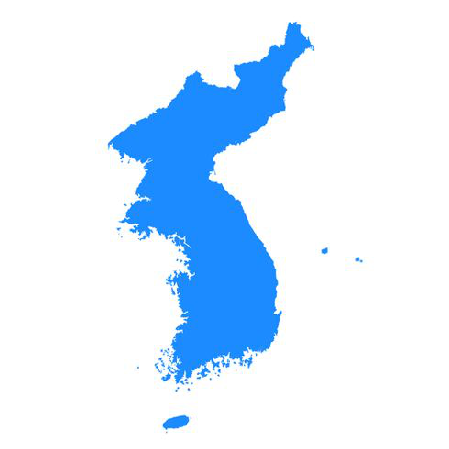

In [12]:
mask = np.array(Image.open("korea.jpg"))
plt.figure(figsize=(16,8))
plt.imshow(mask)
plt.axis('off')
plt.show()

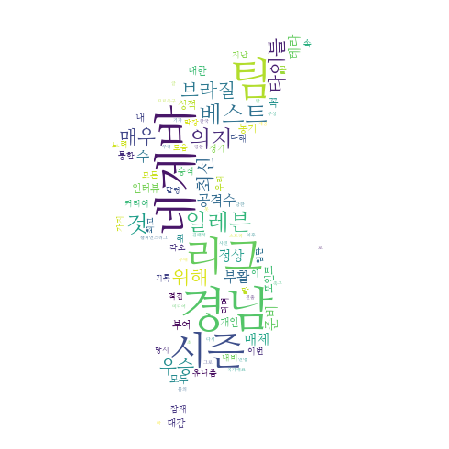

In [13]:
wordcloud = WordCloud( font_path = '/Library/Fonts/NanumMyeongjo.ttf',
                       background_color='white',mask=mask).generate_from_frequencies(tmp_data)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# 네이버 뉴스

In [14]:
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from konlpy.tag import Twitter
import numpy as np
from PIL import Image
res = requests.get('https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=079&aid=0003321490')

In [15]:
soup = BeautifulSoup(res.content, 'html.parser')
body = soup.select('._article_body_contents')[0]
text = body.get_text() # for p in body.find_all('div'))
t = Twitter()
tokens_ko = t.nouns(text)
ko = nltk.Text(tokens_ko, name="스포츠")
ko.vocab().most_common(10)
data = ko.vocab().most_common(1000)

data_1 = []
for i in range(len(data)):
    for q in range(0,1,1):
        if len(data[i][0]) >= 2 :
            data_1.append(data[i])

tmp_data = dict(data_1)

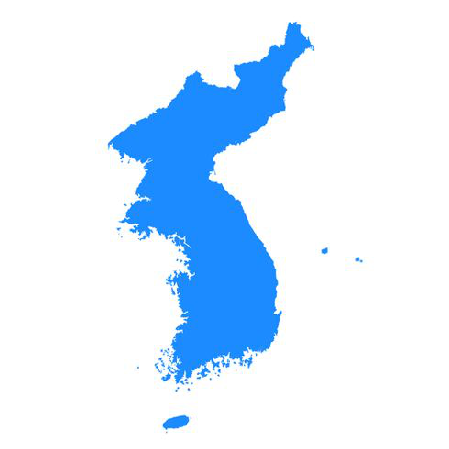

In [16]:
mask = np.array(Image.open("korea.jpg"))
plt.figure(figsize=(16,8))
plt.imshow(mask)
plt.axis('off')
plt.show()

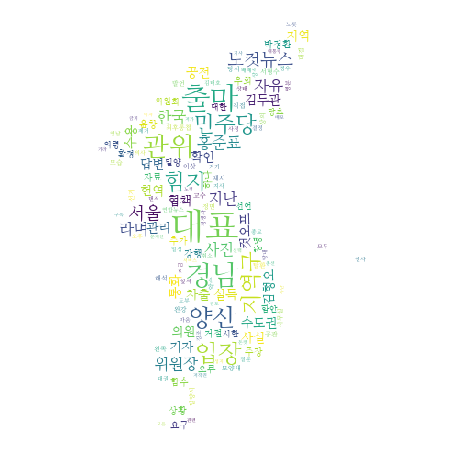

In [22]:
wordcloud = WordCloud( font_path = '/Library/Fonts/NanumMyeongjo.ttf',
                       background_color='white',mask=mask,max_font_size=40).generate_from_frequencies(tmp_data)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# LSTM
- 분류 : 감정분류 ( 긍 부 정 )

In [1]:
import tensorflow as tf

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.90) 
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [4]:
import numpy as np
from keras.datasets import imdb
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM, Embedding,Flatten
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint


np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)
(x_train, y_train), (x_test,y_test) = imdb.load_data(num_words =2000)
np.load = np_load_old

x_train = sequence.pad_sequences(x_train, maxlen=80)
x_test = sequence.pad_sequences(x_test, maxlen=80)
print(x_train[1])

[ 125   68    2    2   15  349  165    2   98    5    4  228    9   43
    2 1157   15  299  120    5  120  174   11  220  175  136   50    9
    2  228    2    5    2  656  245    2    5    4    2  131  152  491
   18    2   32    2 1212   14    9    6  371   78   22  625   64 1382
    9    8  168  145   23    4 1690   15   16    4 1355    5   28    6
   52  154  462   33   89   78  285   16  145   95]


In [5]:
model = Sequential()
model.add(Embedding(2000,128))
model.add(LSTM(128,dropout = 0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])
from keras.callbacks import ModelCheckpoint
che = 'keras_model1.model'
point = ModelCheckpoint(filepath=che , monitor='val_loss', verbose=1, save_best_only=True)

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 387,713
Trainable params: 387,713
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.fit(x_train,y_train,batch_size=32, epochs=15,validation_data = (x_test, y_test),callbacks=[point])



Train on 25000 samples, validate on 25000 samples
Epoch 1/15




25000/25000 [==============================] - 86s 3ms/step - loss: 0.5049 - acc: 0.7517 - val_loss: 0.4480 - val_acc: 0.7984

Epoch 00001: val_loss improved from inf to 0.44804, saving model to keras_model1.model
Epoch 2/15
25000/25000 [==============================] - 89s 4ms/step - loss: 0.3910 - acc: 0.8265 - val_loss: 0.3771 - val_acc: 0.8310

Epoch 00002: val_loss improved from 0.44804 to 0.37714, saving model to keras_model1.model
Epoch 3/15
25000/25000 [==============================] - 84s 3ms/step - loss: 0.3537 - acc: 0.8458 - val_loss: 0.4206 - val_acc: 0.8161

Epoch 00003: val_loss did not improve from 0.37714
Epoch 4/15
25000/25000 [==============================] - 87s 3ms/step - loss: 0.3224 - acc: 0.8599 - val_loss: 0.3639 - val_acc: 0.8400

Epoch 00004: val_loss improved from 0.37714 to 0.36392, saving model to keras_model1.model
Epoch 5/15
25000/25000 [==============================] - 85s 3ms/step -

In [2]:
from keras.models import load_model
model = load_model('keras_model1.model')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [6]:
pred = model.predict(x_train[1])
print(pred,y_train[1])


[[0.49803826]
 [0.5005508 ]
 [0.49918497]
 [0.49918497]
 [0.49646723]
 [0.49934754]
 [0.5028448 ]
 [0.49918497]
 [0.49882588]
 [0.50131786]
 [0.50240004]
 [0.50056404]
 [0.5031885 ]
 [0.5000216 ]
 [0.49918497]
 [0.50171036]
 [0.49646723]
 [0.4990458 ]
 [0.49913752]
 [0.50131786]
 [0.49913752]
 [0.49756512]
 [0.49991181]
 [0.5005222 ]
 [0.50091755]
 [0.49812603]
 [0.49795398]
 [0.5031885 ]
 [0.49918497]
 [0.50056404]
 [0.49918497]
 [0.50131786]
 [0.49918497]
 [0.49765363]
 [0.50181097]
 [0.49918497]
 [0.50131786]
 [0.50240004]
 [0.49918497]
 [0.5025603 ]
 [0.49969774]
 [0.49883285]
 [0.5002455 ]
 [0.49918497]
 [0.5006896 ]
 [0.49918497]
 [0.49923465]
 [0.49989453]
 [0.5031885 ]
 [0.50091124]
 [0.49669582]
 [0.49888086]
 [0.50089633]
 [0.5024026 ]
 [0.50033516]
 [0.4985651 ]
 [0.5031885 ]
 [0.49762985]
 [0.5002439 ]
 [0.49914697]
 [0.49967825]
 [0.50240004]
 [0.49775758]
 [0.49646723]
 [0.5025498 ]
 [0.50240004]
 [0.50090194]
 [0.50131786]
 [0.49702394]
 [0.50091124]
 [0.5005327 ]
 [0.50

In [7]:
dictionary = imdb.get_word_index(path='imdb_word_index.json')
imdb_key=dictionary.keys()
list(imdb_key)[1]


'tsukino'

In [ ]:
# 숙제
# 문제 x_train[1] 문장으로 변환하시오
# model.summary 를 해보고 가중치 사이즈를 계산해보시오

In [8]:
from numba import cuda
cuda.close()